In [1]:
import torch
import random
from collections import Counter
from itertools import combinations

from base_funcs import *
from model import *

from matplotlib import pyplot as plt

import numpy as np

In [12]:
def simEpisode_notrain(Init_states, Models, epsilon, verbose=0):
    if Init_states is None:

        Init_states = init_game() # [Lstate, Dstate, Ustate]

    Log = ''
    Qs = []

    unavail = ''
    history = torch.zeros((15,4,15))
    lastmove = ['',(0,0)]

    Turn = 0
    Npass = 0 # number of pass applying to rules
    Cpass = 0 # continuous pass
    Condition = 0

    Forcemove = True # whether pass is not allowed

    while True: # game loop
        # get player
        #print(Turn, lastmove)
        player, model = Init_states[Turn%3], Models[Turn%3]

        # get card count
        card_count = [int(p.sum()) for p in Init_states]
        #print(card_count)
        CC = torch.zeros((4,15))
        CC[0][:min(card_count[0],15)] = 1
        CC[1][:min(card_count[1],15)] = 1
        CC[2][:min(card_count[2],15)] = 1
        #print(CC)

        # get action
        Bigstate = get_Bigstate(player,unavail,CC,history)
        action,Q = get_action_softmax(Bigstate,lastmove,model,Forcemove,epsilon,'cpu',True)
        
        Qs.append(Q.item())
        if Forcemove:
            Forcemove = False

        # conduct a move
        myst = state2str(player.sum(dim=0).numpy())
        cA = Counter(myst)
        cB = Counter(action[0])
        newst = ''.join(list((cA - cB).elements()))
        newunavail = unavail + action[0]
        newhist = torch.roll(history,1,dims=0)
        newhist[0] = str2state(action[0]) # first row is newest, others are moved downward
        
        #newlast = ['',(0,0)]
        play = action[0]
        if action[1][0] == 0:
            play = 'pass'
            Cpass += 1
            if Npass < 1:
                Npass += 1
            else:
                #print('Clear Action')
                newlast = ['',(0,0)]
                Npass = 0
                Forcemove = True
        else:
            newlast = action
            Npass = 0
            Cpass = 0

        #myst, action[0], newst, newunavail, newhist[0], newlast
        Log += f"{Label[Turn % 3]} {str(Turn).zfill(2)}    {myst.zfill(20).replace('0', ' ')} {play.zfill(20).replace('0', ' ')} by {Label[Turn % 3]}    {str(round(Q.item()*100,1)).zfill(5)}%\n"
        if Cpass == 2:
            Log += '\n'
        if verbose:
            print(Label[Turn%3], str(Turn).zfill(2), '   ', myst.zfill(20).replace('0',' '), play.zfill(20).replace('0',' '), 'by', Label[Turn%3], f'{round(Q.item()*100,1)}%')
            if Cpass == 2:
                print('')
        # record
        nextstate = str2state(newst)


        # update
        Init_states[Turn%3] = nextstate
        unavail = newunavail
        history = newhist
        lastmove = newlast
        
        if len(newst) == 0:
            Condition = 1
            break

        Turn += 1

    #if Condition == 1:
    if Turn %3 == 0:
        Log += f'\nLandlord Wins'
    else:
        Log += f'\nFarmers Win'
    if verbose:
        if Turn %3 == 0:
            print(f'\nLandlord Wins')
        else:
            print(f'\nFarmers Win')
    #print(len(BufferStatesActs[0]),len(BufferRewards[0]))
    #quit()
    return Turn, Qs, Log

In [9]:
Label = ['Landlord','Farmer-0','Farmer-1']
N_history = 15 # number of historic moves in model input

LM, DM, UM = Network_V2(N_history+4),Network_V2(N_history+4),Network_V2(N_history+4)
v_FM = 'H15-V4_0026000000'
v_LM = 'H15-V4_0026000000'
LM.load_state_dict(torch.load(f'models/LM_{v_LM}.pt'))
DM.load_state_dict(torch.load(f'models/DM_{v_FM}.pt'))
UM.load_state_dict(torch.load(f'models/UM_{v_FM}.pt'))

print('Init Wt',LM.fc1.weight.data)

Init Wt tensor([[ 5.3939e-02,  3.5727e-02,  4.5580e-02,  ..., -4.7385e-01,
         -4.6835e-01, -6.6090e-01],
        [ 7.0031e-04,  2.2128e-05, -7.2187e-04,  ..., -6.0976e-04,
          5.5742e-04,  1.0691e-05],
        [-2.4488e-03, -1.0509e-01,  5.8594e-02,  ...,  9.2778e-03,
         -2.9230e-01,  3.8277e-02],
        ...,
        [ 6.7602e-04, -7.6900e-04, -7.6706e-04,  ...,  5.7675e-04,
         -5.3669e-04,  5.3634e-04],
        [ 2.0550e-02, -1.0219e-01,  3.1420e-02,  ...,  6.4275e-02,
          8.1720e-02, -1.5599e-01],
        [ 2.7220e-17, -1.2677e-17, -2.8696e-18,  ..., -9.6556e-17,
          2.1117e-19,  2.4939e-19]])


In [10]:
Deck = init_game()

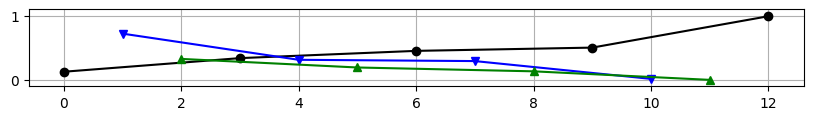

Player Turn |          Current Card |             Action                Win Rate
Landlord 00    344566677889XXXJJJ22              3456789 by Landlord    012.7%
Farmer-0 01       3457789JQKKAAA22R                 pass by Farmer-0    072.0%
Farmer-1 02       334556899XQQQKKAB                 pass by Farmer-1    032.6%

Landlord 03           46678XXXJJJ22             XXXJJJ48 by Landlord    033.9%
Farmer-0 04       3457789JQKKAAA22R                 pass by Farmer-0    031.3%
Farmer-1 05       334556899XQQQKKAB                 pass by Farmer-1    019.3%

Landlord 06                   66722                   66 by Landlord    045.2%
Farmer-0 07       3457789JQKKAAA22R                   77 by Farmer-0    029.3%
Farmer-1 08       334556899XQQQKKAB                 pass by Farmer-1    013.3%
Landlord 09                     722                   22 by Landlord    050.3%
Farmer-0 10         34589JQKKAAA22R                 pass by Farmer-0    001.6%
Farmer-1 11       334556899XQQQKKAB             

In [17]:
Turn = 20
while Turn > 15:
        Turn, Qs, Log = simEpisode_notrain(
        #[str2state('33455788XJJJQKAAA22R'),str2state('3445567799XXJQA22'),str2state('3466678899XQQKKKB')], #v1_029
        None,
        #[i.clone().detach() for i in Deck],
        [LM,DM,UM],0.0,0)
        #break
plt.figure(figsize=(10,1))
plt.plot(range(0,len(Qs),3),Qs[::3],marker='o',color='black')
plt.plot(range(1,len(Qs),3),Qs[1::3],marker='v',color='blue')
plt.plot(range(2,len(Qs),3),Qs[2::3],marker='^',color='green')
plt.ylim(-0.1,1.1)
plt.grid()
plt.show()

print('Player Turn |          Current Card |             Action                Win Rate')
print(Log)

In [11]:
def gamewithplayer(iPlayer, Models, epsilon, verbose=0): # Player is 0, 1, 2 for L, D, U
    Init_states = init_game() # [Lstate, Dstate, Ustate]

    Qs = []

    unavail = ''
    history = torch.zeros((6,4,15))
    lastmove = ['',(0,0)]

    Turn = 0
    Npass = 0 # number of pass applying to rules
    Cpass = 0 # continuous pass
    Condition = 0

    Forcemove = True # whether pass is not allowed

    while True: # game loop
        # get player
        #print(Turn, lastmove)
        player, model = Init_states[Turn%3], Models[Turn%3]

        # get card count
        card_count = [int(p.sum()) for p in Init_states]
        #print(card_count)
        CC = torch.zeros((4,15))
        CC[0][:min(card_count[0],15)] = 1
        CC[1][:min(card_count[1],15)] = 1
        CC[2][:min(card_count[2],15)] = 1
        #print(CC)

        # get action
        Bigstate = get_Bigstate(player,unavail,CC,history)
        action,Q = get_action_softmax(Bigstate,lastmove,model,Forcemove,epsilon,'cpu',True)
        Qs.append(Q.item())
        if Turn % 3 == iPlayer:
            #print(f'Your cards: {state2str(player)}')
            all_acts = avail_actions(lastmove[0],lastmove[1],player,Forcemove)
            while True:
                a = input(f"{Label[Turn%3]}: Your cards: {state2str(player)} Enter your play as string: ")
                action = cards2action(a)
                if action in all_acts:
                    break
                else:
                    print('Illegal Action!')
            
        if Forcemove:
            Forcemove = False

        # conduct a move
        myst = state2str(player)
        cA = Counter(myst)
        cB = Counter(action[0])
        newst = ''.join(list((cA - cB).elements()))
        newunavail = unavail + action[0]
        newhist = torch.roll(history,1,dims=0)
        newhist[0] = str2state(action[0]) # first row is newest, others are moved downward
        
        #newlast = ['',(0,0)]
        play = action[0]
        if action[1][0] == 0:
            play = 'pass'
            Cpass += 1
            if Npass < 1:
                Npass += 1
            else:
                #print('Clear Action')
                newlast = ['',(0,0)]
                Npass = 0
                Forcemove = True
        else:
            newlast = action
            Npass = 0
            Cpass = 0

        #myst, action[0], newst, newunavail, newhist[0], newlast
        if verbose:
            print(Label[Turn%3], str(Turn).zfill(2), '   ', myst.zfill(20).replace('0',' '), play.zfill(20).replace('0',' '), Label[Turn%3], round(Q.item()*100,1), Npass, Cpass)
            if Cpass == 2:
                print('')
        # record
        nextstate = str2state(newst)


        # update
        Init_states[Turn%3] = nextstate
        unavail = newunavail
        history = newhist
        lastmove = newlast
        
        if len(newst) == 0:
            Condition = 1
            break

        Turn += 1

    #if Condition == 1:
    if verbose:
        print(f'Player {Label[Turn%3]} Win')
    #print(len(BufferStatesActs[0]),len(BufferRewards[0]))
    #quit()
    return Turn, Qs

Illegal Action!
Landlord 00     333467889XJJQKKKAAA2                    8 Landlord 57.5 0 0
Farmer-0 01        5555677889XQQQ22B                    X Farmer-0 74.7 0 0
Farmer-1 02        344466799XXJJKA2R                    A Farmer-1 40.5 0 0
Landlord 03      33346789XJJQKKKAAA2                    2 Landlord 52.1 0 0
Farmer-0 04         5555677889QQQ22B                    B Farmer-0 75.0 0 0
Farmer-1 05         344466799XXJJK2R                 pass Farmer-1 57.0 1 1
Landlord 06       33346789XJJQKKKAAA                 pass Landlord 46.5 0 2

Farmer-0 07          5555677889QQQ22             55557788 Farmer-0 88.3 0 0
Farmer-1 08         344466799XXJJK2R                 pass Farmer-1 82.7 1 1
Landlord 09       33346789XJJQKKKAAA                 pass Landlord 26.6 0 2

Farmer-0 10                  69QQQ22                 QQQ6 Farmer-0 87.3 0 0
Farmer-1 11         344466799XXJJK2R                 pass Farmer-1 88.8 1 1
Landlord 12       33346789XJJQKKKAAA                 KKK4 Landlord 25.

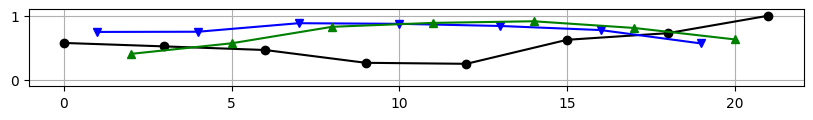

In [12]:
Turn, Qs = gamewithplayer(0,[LM,DM,UM],0.0,1)
plt.figure(figsize=(10,1))
plt.plot(range(0,len(Qs),3),Qs[::3],marker='o',color='black')
plt.plot(range(1,len(Qs),3),Qs[1::3],marker='v',color='blue')
plt.plot(range(2,len(Qs),3),Qs[2::3],marker='^',color='green')
plt.ylim(-0.1,1.1)
plt.grid()
plt.show()